# Amazon Product Review Analysis

# Load libraries 

In [ ]:
from webencodings import labels

pip install transformers

In [ ]:
pip install huggingface_hub[hf_xet]

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json  

import torch 
import transformers 
from sklearn.utils import compute_class_weight
from torch import nn 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [70]:
from torch import cuda 
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cpu')

# Load Dataset

## 1. Review Data

In [3]:
file_path = 'data/review_data.jsonl'
data = []

In [4]:
with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

df_review = pd.DataFrame(data)
df_review.head(5)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5.0,Work great,work great. use a new one every month,[],B01N0TQ0OH,B01N0TQ0OH,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1519317108692,0,True
1,5.0,excellent product,Little on the thin side,[],B07DD2DMXB,B07DD37QPZ,AHWWLSPCJMALVHDDVSUGICL6RUCA,1664746863446,0,True
2,5.0,Happy customer!,"Quick delivery, fixed the issue!",[],B082W3Z9YK,B082W3Z9YK,AHZIJGKEWRTAEOZ673G5B3SNXEGQ,1607225435363,0,True
3,5.0,Amazing value,I wasn't sure whether these were worth it or n...,[],B078W2BJY8,B078W2BJY8,AFGUPTDFAWOHHL4LZDV27ERDNOYQ,1534104184306,0,True
4,5.0,Dryer parts,Easy to install got the product expected to re...,[],B08C9LPCQV,B08C9LPCQV,AELFJFAXQERUSMTXJQ6SYFFRDWMA,1620176603754,0,True


## 2. Meta Data

In [5]:
file_path_meta = 'data/meta_Appliances.jsonl'
data = []

In [6]:
with open(file_path_meta, 'r', encoding='utf-8') as file:
    for line in file:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            continue

df_meta = pd.DataFrame(data)
df_meta.head(5)

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Industrial & Scientific,"ROVSUN Ice Maker Machine Countertop, Make 44lb...",3.7,61,[【Quick Ice Making】This countertop ice machine...,[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Our Point of View on the Euhomy Ic...,ROVSUN,"[Appliances, Refrigerators, Freezers & Ice Mak...","{'Brand': 'ROVSUN', 'Model Name': 'ICM-2005', ...",B08Z743RRD,None,NaN,NaN
1,Tools & Home Improvement,"HANSGO Egg Holder for Refrigerator, Deviled Eg...",4.2,75,"[Plastic, Practical Kitchen Storage - Our egg ...",[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': '10 Eggs Egg Holder for Refrigerato...,HANSGO,"[Appliances, Parts & Accessories, Refrigerator...","{'Manufacturer': 'HANSGO', 'Part Number': 'HAN...",B097BQDGHJ,None,NaN,NaN
2,Tools & Home Improvement,"Clothes Dryer Drum Slide, General Electric, Ho...",3.5,18,[],"[Brand new dryer drum slide, replaces General ...",NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],GE,"[Appliances, Parts & Accessories]","{'Manufacturer': 'RPI', 'Part Number': 'WE1M33...",B00IN9AGAE,None,NaN,NaN
3,Tools & Home Improvement,154567702 Dishwasher Lower Wash Arm Assembly f...,4.5,26,[MODEL NUMBER:154567702 Dishwasher Lower Wash ...,[MODEL NUMBER:154567702 Dishwasher Lower Wash ...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],folosem,"[Appliances, Parts & Accessories, Dryer Parts ...","{'Manufacturer': 'folosem', 'Part Number': '15...",B0C7K98JZS,None,NaN,NaN
4,Tools & Home Improvement,Whirlpool W10918546 Igniter,3.8,12,[This is a Genuine OEM Replacement Part.],[Whirlpool Igniter],25.07,[{'thumb': 'https://m.media-amazon.com/images/...,[],Whirlpool,"[Appliances, Parts & Accessories]","{'Manufacturer': 'Whirlpool', 'Part Number': '...",B07QZHQTVJ,None,NaN,NaN


# Data Check

## 1. Review data

In [7]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2128605 entries, 0 to 2128604
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   rating             float64
 1   title              object 
 2   text               object 
 3   images             object 
 4   asin               object 
 5   parent_asin        object 
 6   user_id            object 
 7   timestamp          int64  
 8   helpful_vote       int64  
 9   verified_purchase  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 148.2+ MB


In [8]:
df_review.count()

rating               2128605
title                2128605
text                 2128605
images               2128605
asin                 2128605
parent_asin          2128605
user_id              2128605
timestamp            2128605
helpful_vote         2128605
verified_purchase    2128605
dtype: int64

In [9]:
df_review.isnull().sum()

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

In [10]:
review_parent_asin = df_review['parent_asin'].unique()
print(review_parent_asin)
print(f"Total unique 'parent_asin' in the reviews dataset: {len(review_parent_asin)}")

['B01N0TQ0OH' 'B07DD37QPZ' 'B082W3Z9YK' ... 'B08V923BM3' 'B08R97ZS3X'
 'B013KDBPSY']
Total unique 'parent_asin' in the reviews dataset: 94319


## 2. Meta data

In [11]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94327 entries, 0 to 94326
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   main_category    89651 non-null  object 
 1   title            94327 non-null  object 
 2   average_rating   94327 non-null  float64
 3   rating_number    94327 non-null  int64  
 4   features         94327 non-null  object 
 5   description      94327 non-null  object 
 6   price            46726 non-null  float64
 7   images           94327 non-null  object 
 8   videos           94327 non-null  object 
 9   store            93411 non-null  object 
 10  categories       94327 non-null  object 
 11  details          94327 non-null  object 
 12  parent_asin      94327 non-null  object 
 13  bought_together  0 non-null      object 
 14  subtitle         5 non-null      object 
 15  author           1 non-null      object 
dtypes: float64(2), int64(1), object(13)
memory usage: 11.5+ MB

In [12]:
df_meta.count()

main_category      89651
title              94327
average_rating     94327
rating_number      94327
features           94327
description        94327
price              46726
images             94327
videos             94327
store              93411
categories         94327
details            94327
parent_asin        94327
bought_together        0
subtitle               5
author                 1
dtype: int64

In [13]:
df_meta.isnull().sum()

main_category       4676
title                  0
average_rating         0
rating_number          0
features               0
description            0
price              47601
images                 0
videos                 0
store                916
categories             0
details                0
parent_asin            0
bought_together    94327
subtitle           94322
author             94326
dtype: int64

In [14]:
meta_parent_asin = df_meta['parent_asin'].unique()
print(meta_parent_asin)
print(f"Total unique 'parent_asin' in the reviews dataset: {len(meta_parent_asin)}")

['B08Z743RRD' 'B097BQDGHJ' 'B00IN9AGAE' ... 'B001EY0RIQ' 'B07JZFJYPK'
 'B01GGKIPE0']
Total unique 'parent_asin' in the reviews dataset: 94327


In [15]:
# Find the common 'parent_asin' values
common_parent_asin = np.intersect1d(review_parent_asin, meta_parent_asin)
print(f"Number of 'parent_asin' values common to both datasets: {len(common_parent_asin)}")

Number of 'parent_asin' values common to both datasets: 94319


In [16]:
print(common_parent_asin)

['0967805929' '1508810133' '1563834103' ... 'B0CK5B9JSX' 'B0CKK87VTT'
 'B0CKR66M1V']


# Data Merge

In [17]:
# Merge two datasets on the common 'parent_asin' column 
# 'how=inner' argument used to ensure that only rows with matching 'parent_asin' values in both datasets are included in the result 
# inner: use intersection of keys from both frames

merged_df = pd.merge(df_review, df_meta, on='parent_asin', how='inner')

In [18]:
merged_df.head(10)

,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,description,price,images_y,videos,store,categories,details,bought_together,subtitle,author
0,5.0,Work great,work great. use a new one every month,[],B01N0TQ0OH,B01N0TQ0OH,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1519317108692,0,True,...,[],9.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Mr Coffee Water Filter Instruction...,Geesta,"[Small Appliance Parts & Accessories, Coffee &...","{'Manufacturer': 'Geesta', 'Part Number': 'Gee...",None,NaN,NaN
1,5.0,excellent product,Little on the thin side,[],B07DD2DMXB,B07DD37QPZ,AHWWLSPCJMALVHDDVSUGICL6RUCA,1664746863446,0,True,...,[],22.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'How To Install An Indoor Dryer Ven...,Essential Values,"[Appliances, Parts & Accessories, Dryer Parts ...","{'Manufacturer': 'Essential Values', 'Part Num...",None,NaN,NaN
2,5.0,Happy customer!,"Quick delivery, fixed the issue!",[],B082W3Z9YK,B082W3Z9YK,AHZIJGKEWRTAEOZ673G5B3SNXEGQ,1607225435363,0,True,...,[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Blutoget make life more convenient...,Romalon,"[Appliances, Parts & Accessories, Dryer Parts ...","{'Manufacturer': 'Romalon', 'Part Number': '27...",None,NaN,NaN
3,5.0,Amazing value,I wasn't sure whether these were worth it or n...,[],B078W2BJY8,B078W2BJY8,AFGUPTDFAWOHHL4LZDV27ERDNOYQ,1534104184306,0,True,...,[FilterLogic FL-RF13 Replacement Refrigerator ...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Overbest NSF Certified Refrigerato...,FilterLogic,"[Appliances, Parts & Accessories, Refrigerator...","{'Material': 'Carbon,Coconut Shell', 'Product ...",None,NaN,NaN
4,5.0,Dryer parts,Easy to install got the product expected to re...,[],B08C9LPCQV,B08C9LPCQV,AELFJFAXQERUSMTXJQ6SYFFRDWMA,1620176603754,0,True,...,[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Your Dryer Has Heating Problem?', ...",Sikawai,"[Appliances, Parts & Accessories, Dryer Parts ...","{'Part Number': '279816', 'Item Weight': '1.8 ...",None,NaN,NaN
5,5.0,DO NOT purchase this ice machine.,After buying this ice machine just 15 months a...,[],B08D6RFV6D,B099ZKQJHK,AEUH4EH6XHROLT7UZPUYU2YKTYMA,1663078878875,0,True,...,"[2-in-1 ice maker, you can get ice water while...",NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Poor fill design and not made for ...,COOLLIFE,"[Appliances, Refrigerators, Freezers & Ice Mak...","{'Brand': 'COOLLIFE', 'Model Name': 'Counterto...",None,NaN,NaN
6,2.0,They don't fit properly,Not the best quality,[],B001TH7GZA,B001TH7H0O,AHCV2CNCOCG6WECDROOUYPDZIFEQ,1610219023865,0,True,...,[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Blutoget creates a happy life for ...,Stanco,"[Appliances, Parts & Accessories, Range Parts ...",{'Product Dimensions': '9.75 x 9.75 x 2.5 inch...,None,NaN,NaN
7,5.0,Five Stars,Part came quickly and fit my LG dryer. Thanks!,[],B00AF7WZTM,B00AF7WZTM,AH6PLOGWYIVIWLJTY756BHNFD4YA,1480334300000,0,True,...,"[Product Description, This high quality Genuin...",46.27,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Whole Parts General Video', 'url':...",LG,"[Appliances, Parts & Accessories, Dryer Parts ...","{'Brand Name': 'LG', 'Model Info': '4774EL2001...",None,NaN,NaN
8,5.0,Five Stars,Always arrive in a fast manner. Descriptions ...,[],B001H05AXY,B001H05AXY,AGCIVNDDRX3PXIUINEG4NCRGWCRA,1427130850000,0,True,...,[Maytag Amana Whirlpool Refrigerator Icemaker ...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],AMANA,"[Appliances, Parts & Accessories]","{'Manufacturer': 'Amana', 'Part Number': 'Wate...",None,NaN,NaN
9,2.0,Company is phenomenal.,The company responded very quickly. Refunded p...,[],B085C6C7WH,B085C6C7WH,AFUOYIZBU3MTBOLYKOJE5Z35MBDA,1630449561325,0,True,...,[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Northair,"[Appliances, Refrigerators, Freezers & Ice Mak...","{'Brand': 'Northair'

In [19]:
# For timestamp, we need to convert the current format to YYYY-M-D type

merged_df['datetime'] = pd.to_datetime(merged_df['timestamp'], unit='ms')

# If the timestamp is already in seconds, you can use the code below
# merged_df['datetime'] = pd.to_datetime(merged_df['timestamp'], unit='s')
merged_df.head(5)

,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,price,images_y,videos,store,categories,details,bought_together,subtitle,author,datetime
0,5.0,Work great,work great. use a new one every month,[],B01N0TQ0OH,B01N0TQ0OH,AGKHLEW2SOWHNMFQIJGBECAF7INQ,1519317108692,0,True,...,9.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Mr Coffee Water Filter Instruction...,Geesta,"[Small Appliance Parts & Accessories, Coffee &...","{'Manufacturer': 'Geesta', 'Part Number': 'Gee...",None,NaN,NaN,2018-02-22 16:31:48.692
1,5.0,excellent product,Little on the thin side,[],B07DD2DMXB,B07DD37QPZ,AHWWLSPCJMALVHDDVSUGICL6RUCA,1664746863446,0,True,...,22.99,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'How To Install An Indoor Dryer Ven...,Essential Values,"[Appliances, Parts & Accessories, Dryer Parts ...","{'Manufacturer': 'Essential Values', 'Part Num...",None,NaN,NaN,2022-10-02 21:41:03.446
2,5.0,Happy customer!,"Quick delivery, fixed the issue!",[],B082W3Z9YK,B082W3Z9YK,AHZIJGKEWRTAEOZ673G5B3SNXEGQ,1607225435363,0,True,...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Blutoget make life more convenient...,Romalon,"[Appliances, Parts & Accessories, Dryer Parts ...","{'Manufacturer': 'Romalon', 'Part Number': '27...",None,NaN,NaN,2020-12-06 03:30:35.363
3,5.0,Amazing value,I wasn't sure whether these were worth it or n...,[],B078W2BJY8,B078W2BJY8,AFGUPTDFAWOHHL4LZDV27ERDNOYQ,1534104184306,0,True,...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[{'title': 'Overbest NSF Certified Refrigerato...,FilterLogic,"[Appliances, Parts & Accessories, Refrigerator...","{'Material': 'Carbon,Coconut Shell', 'Product ...",None,NaN,NaN,2018-08-12 20:03:04.306
4,5.0,Dryer parts,Easy to install got the product expected to re...,[],B08C9LPCQV,B08C9LPCQV,AELFJFAXQERUSMTXJQ6SYFFRDWMA,1620176603754,0,True,...,NaN,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'Your Dryer Has Heating Problem?', ...",Sikawai,"[Appliances, Parts & Accessories, Dryer Parts ...","{'Part Number': '279816', 'Item Weight': '1.8 ...",None,NaN,NaN,2021-05-05 01:03:23.754


In [20]:
# for Sentiment 
df_final = merged_df[['parent_asin', 'main_category', 'user_id', 'title_y', 'title_x', 'datetime', 'text', 'rating', 'rating_number', 'features', 'description', 'price', 'store', 'categories', 'details']]
                      
df_final.head(20)

,parent_asin,main_category,user_id,title_y,title_x,datetime,text,rating,rating_number,features,description,price,store,categories,details
0,B01N0TQ0OH,Tools & Home Improvement,AGKHLEW2SOWHNMFQIJGBECAF7INQ,Geesta 12-Pack Premium Activated Charcoal Wate...,Work great,2018-02-22 16:31:48.692,work great. use a new one every month,5.0,4939,"[EXCEPTIONAL QUALITY AND VALUE: Brew clean, de...",[],9.99,Geesta,"[Small Appliance Parts & Accessories, Coffee &...","{'Manufacturer': 'Geesta', 'Part Number': 'Gee..."
1,B07DD37QPZ,Tools & Home Improvement,AHWWLSPCJMALVHDDVSUGICL6RUCA,Essential Values 18 Pack Compatible Replacemen...,excellent product,2022-10-02 21:41:03.446,Little on the thin side,5.0,3186,[BEST VALUE - Our 18 Pack Of Fine Polyester Re...,[],22.99,Essential Values,"[Appliances, Parts & Accessories, Dryer Parts ...","{'Manufacturer': 'Essential Values', 'Part Num..."
2,B082W3Z9YK,Tools & Home Improvement,AHZIJGKEWRTAEOZ673G5B3SNXEGQ,279838 Dryer Heating Element by Romalon with R...,Happy customer!,2020-12-06 03:30:35.363,"Quick delivery, fixed the issue!",5.0,444,[★【BUY WITH CONFIDENCE】 For any reason you're ...,[],NaN,Romalon,"[Appliances, Parts & Accessories, Dryer Parts ...","{'Manufacturer': 'Romalon', 'Part Number': '27..."
3,B078W2BJY8,Amazon Home,AFGUPTDFAWOHHL4LZDV27ERDNOYQ,"Filterlogic UKF8001 Water Filter, Replacement ...",Amazing value,2018-08-12 20:03:04.306,I wasn't sure whether these were worth it or n...,5.0,355,[The replacement for Maytag UKF8001 refrigerat...,[FilterLogic FL-RF13 Replacement Refrigerator ...,NaN,FilterLogic,"[Appliances, Parts & Accessories, Refrigerator...","{'Material': 'Carbon,Coconut Shell', 'Product ..."
4,B08C9LPCQV,Tools & Home Improvement,AELFJFAXQERUSMTXJQ6SYFFRDWMA,Sikawai 279816 Dryer Thermal Cut-off Kit Repla...,Dryer parts,2021-05-05 01:03:23.754,Easy to install got the product expected to re...,5.0,55,[],[],NaN,Sikawai,"[Appliances, Parts & Accessories, Dryer Parts ...","{'Part Number': '279816', 'Item Weight': '1.8 ..."
5,B099ZKQJHK,Industrial & Scientific,AEUH4EH6XHROLT7UZPUYU2YKTYMA,COOLLIFE Compact Countertop Ice Maker Machine ...,DO NOT purchase this ice machine.,2022-09-13 14:21:18.875,After buying this ice machine just 15 months a...,5.0,506,[Highly Efficient Ice Production - Countertop ...,"[2-in-1 ice maker, you can get ice water while...",NaN,COOLLIFE,"[Appliances, Refrigerators, Freezers & Ice Mak...","{'Brand': 'COOLLIFE', 'Model Name': 'Counterto..."
6,B001TH7H0O,Tools & Home Improvement,AHCV2CNCOCG6WECDROOUYPDZIFEQ,"Stanco 5557 Drip Bowl Universal, Porcelain coa...",They don't fit properly,2021-01-09 19:03:43.865,Not the best quality,2.0,11035,[Fits most plug-in electric ranges * Fits most...,[],NaN,Stanco,"[Appliances, Parts & Accessories, Range Parts ...",{'Product Dimensions': '9.75 x 9.75 x 2.5 inch...
7,B00AF7WZTM,Appliances,AH6PLOGWYIVIWLJTY756BHNFD4YA,LG 4774EL2001A Genuine OEM Door Hinge for LG D...,Five Stars,2016-11-28 11:58:20.000,Part came quickly and fit my LG dryer. Thanks!,5.0,129,[The LG 4774EL2001A Door Hinge is a genuine OE...,"[Product Description, This high quality Genuin...",46.27,LG,"[Appliances, Parts & Accessories, Dryer Parts ...","{'Brand Name': 'LG', 'Model Info': '4774EL2001..."
8,B001H05AXY,Tools & Home Improvement,AGCIVNDDRX3PXIUINEG4NCRGWCRA,Amana Refrigerator Icemaker Water Valve R00002...,Five Stars,2015-03-23 17:14:10.000,Always arrive in a fast manner. Descriptions ...,5.0,59,[Water Valve Inlet allows water exchange and f...,[Maytag Amana Whirlpool Refrigerator Icemaker ...,NaN,AMANA,"[Appliances, Parts & Accessories]","{'Manufacturer': 'Amana', 'Part Number': 'Wate..."
9,B085C6C7WH,Appliances,AFUOYIZBU3MTBOLYKOJE5Z35MBDA,Northair 2 in1 Ice Maker and Water Dispenser w...,Company is phenomenal.,2021-08-31 22:39:21.325,The company responded very quickly. Refunded p...,2.0,223,[【2-in-1 Ice Maker】 2-in-1 Water Dispenser wit...,[],NaN,Northair,"[Appliances, Refrigerators, Freezers & Ice Mak...","{'Brand': 'Northair', 'Model Name': '2 in

In [21]:
df_final.to_csv('data/merged_data.csv', index=False)

# Merged Data Check

In [3]:
df = pd.read_csv('data/merged_data.csv')

## Data Cleaning and EDA

In [4]:
# change name 'title_y' to 'product_name' 
# change name 'title_x' to 'review_title'
# change name 'text' to 'review_text' 
# change name 'parent_asin' to 'product_id'  

df.rename(columns={'title_y': 'product_name', 'title_x': 'review_title', 'text': 'review_text', 'parent_asin': 'product_id'}, inplace=True)

In [5]:
df.head(5)

,product_id,main_category,user_id,product_name,review_title,datetime,review_text,rating,rating_number,features,description,price,store,categories,details
0,B01N0TQ0OH,Tools & Home Improvement,AGKHLEW2SOWHNMFQIJGBECAF7INQ,Geesta 12-Pack Premium Activated Charcoal Wate...,Work great,2018-02-22 16:31:48.692,work great. use a new one every month,5.0,4939,"['EXCEPTIONAL QUALITY AND VALUE: Brew clean, d...",[],9.99,Geesta,"['Small Appliance Parts & Accessories', 'Coffe...","{'Manufacturer': 'Geesta', 'Part Number': 'Gee..."
1,B07DD37QPZ,Tools & Home Improvement,AHWWLSPCJMALVHDDVSUGICL6RUCA,Essential Values 18 Pack Compatible Replacemen...,excellent product,2022-10-02 21:41:03.446,Little on the thin side,5.0,3186,['BEST VALUE - Our 18 Pack Of Fine Polyester R...,[],22.99,Essential Values,"['Appliances', 'Parts & Accessories', 'Dryer P...","{'Manufacturer': 'Essential Values', 'Part Num..."
2,B082W3Z9YK,Tools & Home Improvement,AHZIJGKEWRTAEOZ673G5B3SNXEGQ,279838 Dryer Heating Element by Romalon with R...,Happy customer!,2020-12-06 03:30:35.363,"Quick delivery, fixed the issue!",5.0,444,"[""★【BUY WITH CONFIDENCE】 For any reason you're...",[],NaN,Romalon,"['Appliances', 'Parts & Accessories', 'Dryer P...","{'Manufacturer': 'Romalon', 'Part Number': '27..."
3,B078W2BJY8,Amazon Home,AFGUPTDFAWOHHL4LZDV27ERDNOYQ,"Filterlogic UKF8001 Water Filter, Replacement ...",Amazing value,2018-08-12 20:03:04.306,I wasn't sure whether these were worth it or n...,5.0,355,['The replacement for Maytag UKF8001 refrigera...,['FilterLogic FL-RF13 Replacement Refrigerator...,NaN,FilterLogic,"['Appliances', 'Parts & Accessories', 'Refrige...","{'Material': 'Carbon,Coconut Shell', 'Product ..."
4,B08C9LPCQV,Tools & Home Improvement,AELFJFAXQERUSMTXJQ6SYFFRDWMA,Sikawai 279816 Dryer Thermal Cut-off Kit Repla...,Dryer parts,2021-05-05 01:03:23.754,Easy to install got the product expected to re...,5.0,55,[],[],NaN,Sikawai,"['Appliances', 'Parts & Accessories', 'Dryer P...","{'Part Number': '279816', 'Item Weight': '1.8 ..."


In [6]:
df.shape

(2128605, 15)

In [7]:
# Check duplicates

duplicate_rows = df[df.duplicated()]
print(duplicate_rows.shape)

(22657, 15)


In [8]:
# Remove duplicates 

df = df.drop_duplicates()

In [9]:
# re-check duplicates after removal 

duplicate_rows = df[df.duplicated()]
print(duplicate_rows.shape)

(0, 15)


In [10]:
# Check missing data 

df.isnull().sum()

product_id            0
main_category     28172
user_id               0
product_name         15
review_title        865
datetime              0
review_text         931
rating                0
rating_number         0
features              0
description           0
price            522690
store              6030
categories            0
details               0
dtype: int64

In [11]:
# remove missing data 

df = df.dropna()

In [12]:
# Re-check missing value after removal 

df.isnull().sum()

product_id       0
main_category    0
user_id          0
product_name     0
review_title     0
datetime         0
review_text      0
rating           0
rating_number    0
features         0
description      0
price            0
store            0
categories       0
details          0
dtype: int64

In [13]:
# unique category check

category_unique = df['main_category'].unique()
print(category_unique)
print(f"Total unique 'category' in the reviews dataset: {len(category_unique)}")

['Tools & Home Improvement' 'Appliances' 'Sports & Outdoors' 'Amazon Home'
 'Industrial & Scientific' 'Health & Personal Care' 'Automotive'
 'Office Products' 'Grocery' 'Baby' 'Books' 'AMAZON FASHION'
 'All Electronics' 'Pet Supplies' 'Camera & Photo' 'Toys & Games'
 'All Beauty' 'Home Audio & Theater' 'Cell Phones & Accessories'
 'Arts, Crafts & Sewing' 'Portable Audio & Accessories' 'Computers'
 'Musical Instruments' 'Car Electronics' 'Movies & TV' 'Video Games'
 'Digital Music']
Total unique 'category' in the reviews dataset: 27


In [14]:
# unique product name check

product_title_unique = df['product_name'].unique()
print(product_title_unique)
print(f"Total unique 'products' in the reviews dataset: {len(product_title_unique)}")

['Geesta 12-Pack Premium Activated Charcoal Water Filter Disk for All Mr. Coffee Models'
 'Essential Values 18 Pack Compatible Replacement Filters (90 Dryer Loads Total) for Bettervent Indoor Dryer Vent'
 'LG 4774EL2001A Genuine OEM Door Hinge for LG Dryers' ...
 '3-Pack Replacement for Kenmore/Sears 10650512003 Refrigerator Water Filter - Compatible with Kenmore/Sears 46-9002 Fridge Water Filter Cartridge'
 'W10161215 Lower Rack & wheels Fits for Whirlpool Dishwasher 8561705 8519478 8539225'
 'Primeco 4417EA1002K Washer Motor Stator Compatible for Washer Made by OEM Parts Manufacturer AP5229785, 1519490, 4417EA1002X, AH3522950, EA3522950, PS3522950']
Total unique 'products' in the reviews dataset: 43471


# Sentiment Analyis

## 1. Data Filtering

In [15]:
# extract relevant columns

df_table = df[['product_id', 'main_category', 'user_id', 'product_name', 'review_title', 'datetime', 'review_text', 'rating']]
df_table.head(5)

,product_id,main_category,user_id,product_name,review_title,datetime,review_text,rating
0,B01N0TQ0OH,Tools & Home Improvement,AGKHLEW2SOWHNMFQIJGBECAF7INQ,Geesta 12-Pack Premium Activated Charcoal Wate...,Work great,2018-02-22 16:31:48.692,work great. use a new one every month,5.0
1,B07DD37QPZ,Tools & Home Improvement,AHWWLSPCJMALVHDDVSUGICL6RUCA,Essential Values 18 Pack Compatible Replacemen...,excellent product,2022-10-02 21:41:03.446,Little on the thin side,5.0
7,B00AF7WZTM,Appliances,AH6PLOGWYIVIWLJTY756BHNFD4YA,LG 4774EL2001A Genuine OEM Door Hinge for LG D...,Five Stars,2016-11-28 11:58:20.000,Part came quickly and fit my LG dryer. Thanks!,5.0
10,B09CBF2XCF,Sports & Outdoors,AHPUT3ITXCHQJO7OMF74LEMYHIVA,Perfect Pod EZ-Scoop Coffee Scooper & Funnel f...,Easy use coffee scoop.,2021-03-17 21:09:01.916,Love little kitchen gadgets. Would recommend ...,4.0
11,B09W5PMK5X,Appliances,AHGAOIZVODNHYMNCBV4DECZH42UQ,COMFEE’ Washing Machine 2.4 Cu.ft LED Portable...,so far so good,2022-04-17 00:01:07.807,but i havent had it long a year down the road...,5.0


In [16]:
# sort datetime in ascending order 

df_table = df_table.sort_values('datetime', ascending=True)
df_table.head(5)

,product_id,main_category,user_id,product_name,review_title,datetime,review_text,rating
1945171,B000063D2P,Amazon Home,AEMSE7DHELVXD3W4N7LOP7FAWOGA,Vornado MD1-0002 Replacement Humidifier Wick (...,Decent Price,2003-01-03 17:41:56.000,Decent price for this product. With shipping ...,5.0
615352,B000063D2P,Amazon Home,AGTMIDBMZGCKYMYNN4HFFEK7RZEQ,Vornado MD1-0002 Replacement Humidifier Wick (...,Vornado Humidifier Wicks,2003-02-20 18:46:22.000,One thing that stands out is that instead of t...,5.0
58734,B000063D2P,Amazon Home,AHC3CU6TGIJHWA5V4T47IIRTNOCA,Vornado MD1-0002 Replacement Humidifier Wick (...,Great wicks,2003-06-04 04:14:46.000,"Yep, hard to review something like this. These...",5.0
517767,B000063D2P,Amazon Home,AFCJPKH344LOVYMIBLUXLUFU2ZZQ,Vornado MD1-0002 Replacement Humidifier Wick (...,One Size Fits All,2003-11-17 21:30:54.000,"Coolest thing about these, they fit ANY Vornad...",5.0
1147877,B01251BJX8,Amazon Home,AFWXKMGL2ZWP2ZG2MFDIC66XHYHA,"KRUPS F0494210 Gold Tone Permanent Filter, Black",Great filter...long-lasting,2003-12-02 23:33:28.000,My husband and I bought this filter when we fi...,5.0


In [17]:
df_table.tail()

,product_id,main_category,user_id,product_name,review_title,datetime,review_text,rating
2125284,B07SHFKCR7,Amazon Home,AHHUVYZQVMLWJBJZFWBZ4D42V7UQ,Milk Frothing Pitcher Jug - 12oz/350ML Stainle...,Spoons are lovely!,2023-09-11 00:55:53.696,This is very sturdy but a little bit short for...,4.0
2121485,B07BTT18PV,Tools & Home Improvement,AFIVUBCIF5LOCWY6CIYCHBCOXIAA,Ultra Durable W10820039 280145 Washer Hub Kit ...,correct fit,2023-09-11 11:16:33.144,all good,5.0
2124300,B0C5BHXVH1,Amazon Home,AF5EU7C44MHOOQEP4FNAHJ3OMEQQ,Pureline EDR4RXD1 Replacement for Everydrop Fi...,the price is greatLike,2023-09-11 14:10:30.523,Liked,5.0
2126249,B08YNLGRV5,Appliances,AFLMRXASCRBRRAJKBWAX3HSPC4MA,HAOCHEN Safe Ice Maker/Refrigerator Water Line...,Nice kit,2023-09-12 08:28:10.033,Decent little kit with multiple set ups to att...,5.0
2127280,B07KP6X4YK,Amazon Home,AE3IYKHXWNLWXVJU3ZVYCAKHFIRQ,Waterspecialist DA97-17376B Replacement for Sa...,They worked perfectly,2023-09-12 16:29:17.016,They were easy to install and they worked great,5.0


### 1.1. Filter Datetime
The dataset has review data from 2003 to 2023. To improve computational resources and catch recent customer trend, we will focus on analyzing data from 2013 to 2023. 

In [18]:
# Filter dataset based on datatime from 2013 to 2023
df_table['datetime'] = pd.to_datetime(df_table['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
filtered_df = df_table[(df_table['datetime'].dt.year >= 2013) & (df_table['datetime'].dt.year <= 2023)]
filtered_df.head(5)

,product_id,main_category,user_id,product_name,review_title,datetime,review_text,rating
273794,B004XLDEAU,Tools & Home Improvement,AGCHQLEBAS4UEV4N7UGALCBVLPCA,"Whirlpool 279834 Valve Coil for Dryer, Black",Worked like a champ,2013-01-01 00:24:41,Historically I have always fixed my own applia...,5.0
2024607,B004XLDELE,Tools & Home Improvement,AF5L3BRNG4JS5W2CPRSRMTTLX6PQ,"Whirlpool 279973 Dryer Thermostat, White",I'm satisfied,2013-01-01 00:40:19,"I'm satisfied with the product obtained, since...",4.0
1689082,B0B9H5NZRD,Amazon Home,AE5X2MXZCOR6SXFZBQ2BHF6VI4PQ,"Reston Lloyd Electric Stove Burner Covers, Set...",Stovetop covers,2013-01-01 01:11:35,The burner covers are beautiful and really dre...,5.0
567225,B0053Y2KTW,Tools & Home Improvement,AGLIVLNBJ3D4K4Z37T5ICN3VOLXQ,Whirlpool W10293048 Gas Valve for Range,excellent,2013-01-01 02:12:53,"item was as described and new in package, was ...",5.0
1094493,B004XLE7O2,Tools & Home Improvement,AHEGFJVJLF7ZT4CYSVFWIRK3QQXA,Whirlpool 2223320 Track for Refrigerator,Perfect Fit,2013-01-01 02:41:05,Perfect fit and worked well right away. Insta...,5.0


In [19]:
filtered_df.count()

product_id       1553881
main_category    1553881
user_id          1553881
product_name     1553881
review_title     1553881
datetime         1553881
review_text      1553881
rating           1553881
dtype: int64

### 1.2. Filter Categories
We want to filter product categories due to computational resources. 

In [20]:
# check how many reviewes are registered, per category 

review_counts = filtered_df.groupby('main_category').size()
print(review_counts)

main_category
AMAZON FASHION                     930
All Beauty                         466
All Electronics                   1938
Amazon Home                     437625
Appliances                      405932
Arts, Crafts & Sewing              136
Automotive                        6200
Baby                              2167
Books                               92
Camera & Photo                    1683
Car Electronics                     95
Cell Phones & Accessories          505
Computers                          228
Grocery                          10420
Health & Personal Care            5627
Home Audio & Theater               430
Industrial & Scientific          76152
Movies & TV                          3
Musical Instruments                258
Office Products                   1166
Pet Supplies                       342
Portable Audio & Accessories       251
Sports & Outdoors                 4167
Tools & Home Improvement        596706
Toys & Games                       360
Video Games

* Amazon Home, Appliances, Tools & Home Improvement will be excluded (too many reviews)
* All Electronics (1938), Automative (6200), Baby (2167), Health & Personal Care (5627), Sports & Outdoors (4167), Office Products (1166) will be included  
* Other categories will be excluded 


In [49]:
target_categories = [
    'All Electronics',
    'Automotive',
    'Baby',
    'Camera & Photo',
    'Health & Personal Care',
    'Sports & Outdoors',
    'Office Products'
]

# .isin() method for target categories
filtered_df_2 = filtered_df[filtered_df['main_category'].isin(target_categories)]

# check the result 

print(f"Original DataFrame size: {len(filtered_df)} rows")
print(f"Filtered DataFrame size: {len(filtered_df_2)} rows")

# Check the unique categories in the new, smaller DataFrame
print("\nUnique categories in the filtered dataset:")
print(filtered_df_2['main_category'].unique())

Original DataFrame size: 1553881 rows
Filtered DataFrame size: 22948 rows

Unique categories in the filtered dataset:
['Office Products' 'Automotive' 'Health & Personal Care' 'Camera & Photo'
 'Baby' 'All Electronics' 'Sports & Outdoors']


**Copy the dataset. We will use the copied dataset 'df'.**

In [50]:
# copy the dataset
df = filtered_df_2.copy()

In [51]:
df.count()

product_id       22948
main_category    22948
user_id          22948
product_name     22948
review_title     22948
datetime         22948
review_text      22948
rating           22948
dtype: int64

In [52]:
# check unique count per rating 

rating_counts = df.groupby('rating').size()
print(rating_counts)

rating
1.0     2423
2.0      885
3.0     1193
4.0     2325
5.0    16122
dtype: int64


In [54]:
# convert rating numbers to positive, negative, and neutral 
# Positive: 4.0 and 5.0
# Neutral: 3.0 
# Negative: 1.0, 2.0 

def assign_sentiment(rating):
    """
    Converts a numerical rating into a categorial sentiment label
    """
    
    if rating >= 4.0:
        return 'Positive'
    elif rating == 3.0:
        return 'Neutral'
    elif rating < 3.0:
        return 'Negative'
    else:
        return 'Unknown'

# Apply the function to the 'rating' column and save the result 
df['sentiment_label'] = df['rating'].apply(assign_sentiment)

# check sentiment 
print(df['sentiment_label'].value_counts())

df.head(5)

sentiment_label
Positive    18447
Negative     3308
Neutral      1193
Name: count, dtype: int64


,product_id,main_category,user_id,product_name,review_title,datetime,review_text,rating,sentiment_label
687152,B002YI2UTK,Office Products,AHG376YJZ366GN2YTJBFMSRQ3CHA,"BUNN BCF100BCT Coffee Filters, 8/10-Cup Size, ...",No Matter What Brand,2013-01-01 05:07:27,"of coffee maker you use, I highly recommend th...",5.0,Positive
1450889,B001AQZI64,Automotive,AETQGCLHV4O6AGZ6A47M4TGI2ZAQ,"RoadPro RPBH-012 12-Volt Beverage Heater, Black",boiling water,2013-01-01 15:47:16,The device enables me to make tea or heat up m...,4.0,Positive
1475695,B008O57G5U,Health & Personal Care,AET2PQGJT5QAPCUAF7XSNXF5A5BQ,ProTec PC-2 Humidifier Tank Cleaning Cartridge...,Great for your humidifer,2013-01-02 00:57:29,I have used these with my humidifer ever since...,5.0,Positive
1105823,B004MDLZKU,Office Products,AFR3IN2FKPYXGNUYGKS2VQR5QM4Q,"BUNN A101M500S Coffee Brewer Filters, 10-Cup, ...",Great filters,2013-01-02 13:07:57,We were using some off brand filters before ge...,5.0,Positive
253126,B07B9N9S1C,Health & Personal Care,AEOBRGA6QBCNACI2LWEE5K5TE5XA,3 Packs :1 X ROCKLINE BASKET COFFEE FILTERS (8...,Perfect for the price,2013-01-03 06:04:09,"Well, they are just coffee filters. I have bou...",5.0,Positive


## 2. Text Cleaning

Before spliting the dataset, we need to clean the text data, removing number, special characters, etc. 

In [58]:
# function to clean review data 

def text_cleaning(text):
    
    text = str(text).lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove URLs 
    text = re.sub(r'http\S+|www\S+', ' ', text)
    
    # Remove anything that isn't a word character, number, punctuation, or space 
    # Note: \w includes a-z, A-Z, 0-9, and underscore. Punctuation is kept.
    text = re.sub(r'[^\w\s\.\,\!\?\(\)\-\'\"\/]', ' ', text)
    
    # Replace multiple spaces with a single space (Normalization)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text
    

In [59]:
df['cleaned_text'] = df['review_text'].apply(text_cleaning)
df.head(5)

,product_id,main_category,user_id,product_name,review_title,datetime,review_text,rating,sentiment_label,cleaned_text
687152,B002YI2UTK,Office Products,AHG376YJZ366GN2YTJBFMSRQ3CHA,"BUNN BCF100BCT Coffee Filters, 8/10-Cup Size, ...",No Matter What Brand,2013-01-01 05:07:27,"of coffee maker you use, I highly recommend th...",5.0,Positive,"of coffee maker you use, i highly recommend th..."
1450889,B001AQZI64,Automotive,AETQGCLHV4O6AGZ6A47M4TGI2ZAQ,"RoadPro RPBH-012 12-Volt Beverage Heater, Black",boiling water,2013-01-01 15:47:16,The device enables me to make tea or heat up m...,4.0,Positive,the device enables me to make tea or heat up m...
1475695,B008O57G5U,Health & Personal Care,AET2PQGJT5QAPCUAF7XSNXF5A5BQ,ProTec PC-2 Humidifier Tank Cleaning Cartridge...,Great for your humidifer,2013-01-02 00:57:29,I have used these with my humidifer ever since...,5.0,Positive,i have used these with my humidifer ever since...
1105823,B004MDLZKU,Office Products,AFR3IN2FKPYXGNUYGKS2VQR5QM4Q,"BUNN A101M500S Coffee Brewer Filters, 10-Cup, ...",Great filters,2013-01-02 13:07:57,We were using some off brand filters before ge...,5.0,Positive,we were using some off brand filters before ge...
253126,B07B9N9S1C,Health & Personal Care,AEOBRGA6QBCNACI2LWEE5K5TE5XA,3 Packs :1 X ROCKLINE BASKET COFFEE FILTERS (8...,Perfect for the price,2013-01-03 06:04:09,"Well, they are just coffee filters. I have bou...",5.0,Positive,"well, they are just coffee filters. i have bou..."


## 3. Data Split

Since the dataset has datetime. we will split the dataset into train set and test set, based on datetime.

In [61]:
# we will use 70:30 split 

train_size = int(0.7 * len(df))

# training set 70%
train_df = df.iloc[:train_size]

# test set 30% 
test_df = df.iloc[train_size:]

print(f"Traing Date Range: {train_df['datetime'].min()} to {train_df['datetime'].max()}")
print(f"Test Date Range: {test_df['datetime'].min()} to {test_df['datetime'].max()}")

Traing Date Range: 2013-01-01 05:07:27 to 2021-06-08 18:40:28.246000
Test Date Range: 2021-06-08 21:50:01.598000 to 2023-08-27 21:59:23.410000


In [85]:
print(train_df.shape)
print(test_df.shape)

(16063, 11)
(6885, 11)


## 4. Classification using DistilBERT (Distilled version of BERT)

In [87]:
# X_train, y_train 
# X_test, y_test 
# X is 'cleaned_text', y is 'label'

def train_test(df):
    df['label'] = df['sentiment_label'].map({'Positive': 0, 'Negative': 1, 'Neutral':2})
    return df['cleaned_text'].tolist(), df['label'].tolist()

In [88]:
X_train, y_train = train_test(train_df)
X_test, y_test = train_test(test_df)

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

16063 16063
6885 6885


C:\Users\Hyeon\AppData\Local\Temp\ipykernel_13928\3396190753.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['sentiment_label'].map({'Positive': 0, 'Negative': 1, 'Neutral':2})
C:\Users\Hyeon\AppData\Local\Temp\ipykernel_13928\3396190753.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['sentiment_label'].map({'Positive': 0, 'Negative': 1, 'Neutral':2})


### 4.1. Class Imbalance Check - Train set and Test set

In [86]:
print(f"Train set label: {train_df['sentiment_label'].value_counts()}")
print(f"Test set label: {test_df['sentiment_label'].value_counts()}")

Train set label: sentiment_label
Positive    13089
Negative     2129
Neutral       845
Name: count, dtype: int64
Test set label: sentiment_label
Positive    5358
Negative    1179
Neutral      348
Name: count, dtype: int64


**As we can see, 'Negative' and 'Neutral' are heavily unbalanced, compared to 'Positive' data. Since BERT model will be used, We will try to solve class imbalance issue 
using Class weight.** 

### 4.2. Calculate Class weight

In [91]:
# Handling Class Imbalance

# define the counts and classes
counts = np.array([13089, 2129, 845])
classes = np.array([0, 1, 2])

y_for_weights = np.repeat(classes, counts)

weights = compute_class_weight(class_weight = 'balanced', classes=classes, y=y_for_weights)

class_weights = weights 
print(class_weights)


[0.40907123 2.51495225 6.33648915]


In [92]:
# Prepare weights 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [95]:
# Define Loss Function with Weights 
# the CrossEntropyLoss function will use weights to scale the loss 
# for each class during the backward pass. 

loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

### 4.3. Custom Dataset 

In [98]:
# Create a custom dataset

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer 
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        } 

In [100]:
# Initialize Tokenizer and create datasets 

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_dataset = SentimentDataset(X_train, y_train, tokenizer)
test_dataset = SentimentDataset(X_test, y_test, tokenizer)

# Create data loaders

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

### 4.4 Initialize DistilBERT Model 

In [103]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [104]:
# Set optimizer AdamW 
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [105]:
# Trainig loop 
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        
    # Test set evaluation
    model.eval()
    test_preds = []
    test_true = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.numpy())
            
    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')
    
torch.save(model.state_dict(), 'sentiment_model.pth')

# training time: 3h 40 mins     


Epoch 1/5, Test Accuracy: 0.7068
Epoch 2/5, Test Accuracy: 0.8086
Epoch 3/5, Test Accuracy: 0.8215
Epoch 4/5, Test Accuracy: 0.8590
Epoch 5/5, Test Accuracy: 0.8353


### 4.5. Evaluation 

In [106]:
print(classification_report(test_true, test_preds, target_names=['Positive', 'Negative', 'Neutral']))

              precision    recall  f1-score   support

    Positive       0.96      0.89      0.92      5358
    Negative       0.77      0.71      0.74      1179
     Neutral       0.19      0.46      0.27       348

    accuracy                           0.84      6885
   macro avg       0.64      0.69      0.64      6885
weighted avg       0.89      0.84      0.86      6885



[[4752  140  466]
 [ 111  838  230]
 [  73  114  161]]


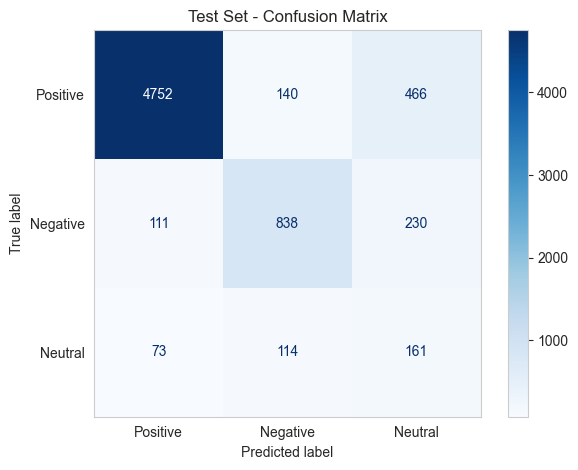

In [110]:
# Check if test_true labels need conversion
if not isinstance(test_true[0], str):
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    test_true_encoded = encoder.fit_transform(test_true)
    labels = [0, 1, 2]
else:
    test_true_encoded = test_true
    labels = ['Positive', 'Negative', 'Neutral']

# calculate confusion matrix 
confusion_matrix_table = confusion_matrix(test_true, test_preds, labels=labels)
print(confusion_matrix_table)

labels=['Positive', 'Negative', 'Neutral']
test_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_table, display_labels=labels)
test_display.plot(cmap='Blues')
plt.title("Test Set - Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

## 5. Conclusion

**1. High Accuracy**    
The training process returned a high accuracy 84%. However, the result is misleading because it is dominated by the positive class. the vast majority of the test data comes from positive target. 

**2. 'Neutral' class**  
Unlike 'Positive' and 'Negative' classes that returned acceptable f1 score '92%' and '74%' respectively, 'Neutral' class returned low f1 score '27%'. The 'Neutral' class has the lowest support (test sample, only 348), leading the poor performance. We used class weighting during training. Although the class weight was 6.33 (highest weights) for Neutral class, 348 samples is a very small number for a model to learn the lingustic nuances, compared to 5358 positive samples. 